## Setup

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
#Import the visualization libraries
import seaborn as sn
import matplotlib.pyplot as plt

## Preparing Data

In [ ]:
dataframe = pd.read_csv('/content/drive/MyDrive/Data Skripsi/data-firebase/raw-data/newestdata.csv')
dataframe.drop(['z_count', 'Ts', '_key', 'bitSoilSensor1', 'bitSoilSensor2', 'voltageSoilSense1', 'voltageSoilSense2', 'week', 'percentageSoilSensor1'], axis=1, inplace=True)
display(dataframe.head(10))
original_dataframe = dataframe.copy(deep=True)

,percentageSoilSensor2,roomHumidity,roomTemperature,status
0,82,99.6,30.0,0.0
1,83,98.1,30.0,0.0
2,81,98.9,30.2,0.0
3,82,98.7,30.5,0.0
4,84,97.5,31.0,0.0
5,83,97.1,31.5,0.0
6,82,96.4,31.9,0.0
7,83,96.1,32.1,0.0
8,82,96.6,32.2,0.0
9,83,95.9,32.5,0.0


In [ ]:
def features_build(dataframe):
    dataframe["Date"] = pd.to_datetime(dataframe["Ts"], unit='ms')
    dataframe["Date"] = dataframe['Date'].dt.tz_localize('UTC').dt.tz_convert('Asia/Jakarta')
    dataframe["Date"] = dataframe['Date'].dt.tz_localize(None)
    dataframe['Day'] = dataframe.Date.dt.day
    dataframe['Hour'] = dataframe.Date.dt.hour
features_build(dataframe)
dataframe.drop(['Ts', 'Date'], axis=1, inplace=True)
dataframe

,percentageSoilSensor1,percentageSoilSensor2,roomHumidity,roomTemperature,status,Day,Hour
0,63,82,99.6,30.0,0.0,29,8
1,71,82,96.4,31.9,0.0,29,9
2,71,82,94.9,33.0,1.0,29,10
3,72,82,95.4,33.0,0.0,29,11
4,72,82,95.4,33.0,0.0,29,12
...,...,...,...,...,...,...,...
1016,90,97,99.9,33.4,0.0,10,9
1017,92,98,99.9,33.5,0.0,10,9
1018,90,98,98.7,34.8,0.0,10,10
1019,90,98,97.5,34.9,0.0,10,10


In [ ]:
# dataframe['Date'] = pd.to_datetime(dataframe['Date'])
# dataframe = dataframe.resample('H', on='Date').mean().reset_index()
# dataframe.drop(['Date'])
dataframe.head(10)

,percentageSoilSensor2,roomHumidity,roomTemperature,status
0,82,99.6,30.0,0.0
1,83,98.1,30.0,0.0
2,81,98.9,30.2,0.0
3,82,98.7,30.5,0.0
4,84,97.5,31.0,0.0
5,83,97.1,31.5,0.0
6,82,96.4,31.9,0.0
7,83,96.1,32.1,0.0
8,82,96.6,32.2,0.0
9,83,95.9,32.5,0.0


In [ ]:
dataframe.isnull().values.any()

True

In [ ]:
dataframe.isnull().sum()

percentageSoilSensor2    0
roomHumidity             0
roomTemperature          0
status                   1
dtype: int64

In [ ]:
dataframe = dataframe.dropna()

In [ ]:
dataframe.isnull().sum()

percentageSoilSensor2    0
roomHumidity             0
roomTemperature          0
status                   0
dtype: int64

###Changing status from float to int

In [ ]:
dataframe

,percentageSoilSensor2,roomHumidity,roomTemperature,status
0,82,99.6,30.0,0.0
1,83,98.1,30.0,0.0
2,81,98.9,30.2,0.0
3,82,98.7,30.5,0.0
4,84,97.5,31.0,0.0
...,...,...,...,...
9640,57,99.9,28.9,1.0
9641,57,99.9,28.9,1.0
9642,56,99.9,29.1,1.0
9643,57,99.9,29.6,1.0


In [ ]:
dataframe['status'] = dataframe['status'].astype(int)

In [ ]:
dataframe.shape

(9644, 4)

In [ ]:
val_dataframe = dataframe.sample(frac=0.2)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 7715 samples for training and 1929 for validation


In [ ]:
val_dataframe

,percentageSoilSensor2,roomHumidity,roomTemperature,status
1991,76,99.9,26.0,0
5040,96,95.0,34.6,0
3925,95,99.9,26.6,0
3138,92,99.9,25.6,0
7293,93,99.9,25.8,0
...,...,...,...,...
1537,92,98.7,28.5,0
7674,97,99.9,35.9,0
6947,94,99.9,27.9,0
3020,92,99.8,32.6,0


In [ ]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("status")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

In [ ]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Status:", y)

Input: {'percentageSoilSensor2': <tf.Tensor: shape=(), dtype=int64, numpy=93>, 'roomHumidity': <tf.Tensor: shape=(), dtype=float64, numpy=99.9>, 'roomTemperature': <tf.Tensor: shape=(), dtype=float64, numpy=28.9>}
Status: tf.Tensor(0, shape=(), dtype=int64)


In [ ]:
train_ds = train_ds.batch(16)
val_ds = val_ds.batch(16)

## Feature preprocessing with Keras layers

In [ ]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

## Build a model

In [ ]:
# percentageSoilSensor1 = keras.Input(shape = (1,), name='percentageSoilSensor1')
percentageSoilSensor2 = keras.Input(shape = (1,), name='percentageSoilSensor2')
roomHumidity = keras.Input(shape = (1,), name='roomHumidity')
roomTemperature = keras.Input(shape = (1,), name='roomTemperature')
all_inputs = [
              percentageSoilSensor2, roomHumidity, roomTemperature 
]

In [ ]:
# percentageSoilSensor1_encoded = encode_numerical_feature(percentageSoilSensor1, 'percentageSoilSensor1', train_ds)
percentageSoilSensor2_encoded = encode_numerical_feature(percentageSoilSensor2, 'percentageSoilSensor2', train_ds)
roomHumidity_encoded = encode_numerical_feature(roomHumidity, 'roomHumidity', train_ds)
roomTemperature_encoded = encode_numerical_feature(roomTemperature, 'roomTemperature', train_ds)
all_features = layers.concatenate(
    [
     percentageSoilSensor2_encoded, roomHumidity_encoded, roomTemperature_encoded
    ]
)

In [ ]:
# x = tf.keras.Sequential([
#               tf.keras.layers.Dense(64, activation='relu')(all_features),
#               tf.keras.layers.Dense(32, activation='relu'),
#               tf.keras.layers.Dropout(0.1),
#               tf.keras.layers.Dense(1, activation='sigmoid')
# ])
x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.2)(x)
x = layers.Dense(16, activation= "relu")(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

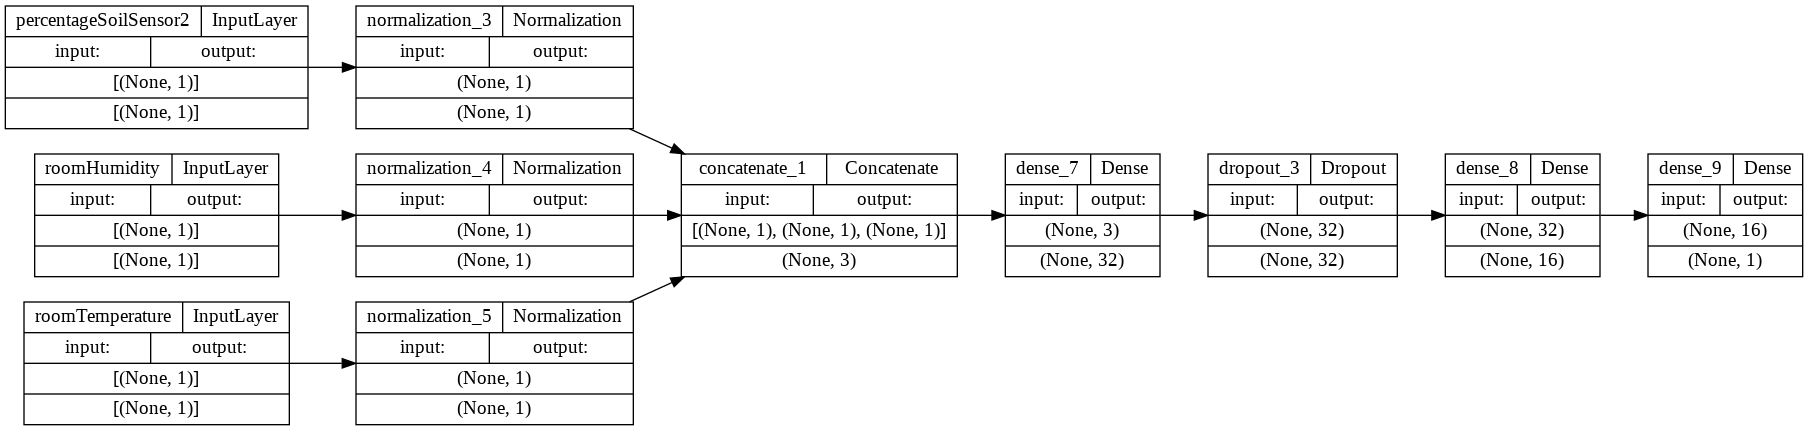

In [ ]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

## Train Model

In [ ]:
history = model.fit(train_ds, epochs=25, validation_data=val_ds)

Epoch 1/25
483/483 [==============================] - 2s 2ms/step - loss: 0.2481 - accuracy: 0.9358 - val_loss: 0.1405 - val_accuracy: 0.9528
Epoch 2/25
483/483 [==============================] - 1s 2ms/step - loss: 0.1263 - accuracy: 0.9580 - val_loss: 0.1310 - val_accuracy: 0.9565
Epoch 3/25
483/483 [==============================] - 1s 2ms/step - loss: 0.1224 - accuracy: 0.9596 - val_loss: 0.1248 - val_accuracy: 0.9559
Epoch 4/25
483/483 [==============================] - 1s 2ms/step - loss: 0.1182 - accuracy: 0.9610 - val_loss: 0.1234 - val_accuracy: 0.9559
Epoch 5/25
483/483 [==============================] - 1s 2ms/step - loss: 0.1148 - accuracy: 0.9631 - val_loss: 0.1171 - val_accuracy: 0.9632
Epoch 6/25
483/483 [==============================] - 1s 2ms/step - loss: 0.1114 - accuracy: 0.9619 - val_loss: 0.1185 - val_accuracy: 0.9596
Epoch 7/25
483/483 [==============================] - 1s 2ms/step - loss: 0.1099 - accuracy: 0.9631 - val_loss: 0.1161 - val_accuracy: 0.9642
Epoch 

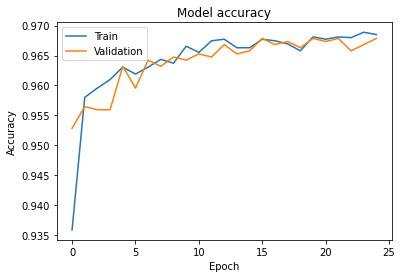

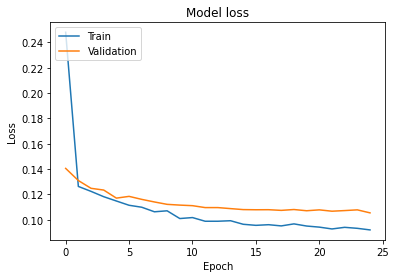

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
sample = {
    "percentageSoilSensor2": 50,
    "roomTemperature" : 29,
    "roomHumidity" : 99

}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
    "This particular Percentage had a %.1f percent probability "
    "of getting Stepper Motor online, as evaluated by our model." % (100 * predictions[0][0],)
)

This particular Percentage had a 71.2 percent probability of getting Stepper Motor online, as evaluated by our model.


In [ ]:
model.save('/content/drive/MyDrive/Data Skripsi/data-firebase/saved_model/water_status_v3_Dense_DNN.h5') 

## Import .h5

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Data Skripsi/data-firebase/saved_model/water_status_v3_Dense_DNN.h5')

In [ ]:
sample = {
    "percentageSoilSensor2": 50,
    "roomTemperature" : 29,
    "roomHumidity" : 99

}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
    "This particular Percentage had a %.1f percent probability "
    "of getting Stepper Motor online, as evaluated by our model." % (100 * predictions[0][0],)
)

This particular Percentage had a 71.2 percent probability of getting Stepper Motor online, as evaluated by our model.


In [ ]:
model.fit(val_ds)

121/121 [==============================] - 2s 5ms/step - loss: 0.0889 - accuracy: 0.9730


In [ ]:
val_ds

<BatchDataset element_spec=({'percentageSoilSensor2': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'roomHumidity': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'roomTemperature': TensorSpec(shape=(None,), dtype=tf.float64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>